<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train HMM


In [1]:
import sys
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
sns.set(color_codes=True)

In [2]:
COMPUTE_ENGINE_SRC_PATH = "../compute_engine/src/"

if COMPUTE_ENGINE_SRC_PATH not in sys.path:
    sys.path.append(COMPUTE_ENGINE_SRC_PATH)


In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import plot_state
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [6]:
# change the paths here accordingly 

# DUPLICATION Traininng indices: (103419900,103922100)
# DELETE Training indices: (25050350, 25552650)
# TUF I Training indices: (19001200, 19126800)
# SINGLE COPY DELETION Training indices: (34408800, 34595200) chr2

wga_mean_tuf_I_file = "../data/train/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_tuf_I_file = "../data/train/no_wga_windows_mean_0_TUF_DETAIL_I.txt"

wga_mean_single_copy_deletion_file = "../data/train/wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
no_wga_mean_single_copy_deletion_file = "../data/train/no_wga_windows_mean_0_SINGLE_COPY_DELETION.txt"

wga_mean_duplication_file = "../data/train/wga_windows_mean_0_DUPLICATION.txt"
no_wga_mean_duplication_file = "../data/train/no_wga_windows_mean_0_DUPLICATION.txt"

wga_mean_delete_file = "../data/train/wga_windows_mean_0_DELETE.txt"
no_wga_mean_delete_file = "../data/train/no_wga_windows_mean_0_DELETE.txt"

In [7]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)

wga_mu_single_copy_deletion = load_data_file(filename=wga_mean_single_copy_deletion_file)
no_wga_mu_single_copy_deletion = load_data_file(filename=no_wga_mean_single_copy_deletion_file)

wga_mu_duplication = load_data_file(filename=wga_mean_duplication_file)
no_wga_mu_duplication = load_data_file(filename=no_wga_mean_duplication_file)

wga_mu_delete = load_data_file(filename=wga_mean_delete_file)
no_wga_mu_delete = load_data_file(filename=no_wga_mean_delete_file)


In [8]:
# mix the data

# WGA sample
wga_mu = []
wga_mu.extend(wga_mu_single_copy_deletion)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_delete)


# NO-WGA sample
no_wga_mu = []
no_wga_mu.extend(no_wga_mu_single_copy_deletion)
no_wga_mu.extend(no_wga_mu_duplication)
no_wga_mu.extend(no_wga_mu_delete)


## Cluster the reference data

In [9]:
# Dictionay that holds the states for the HMM 
states={}

In [10]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  154276.1382869141
Len of labels:  11741


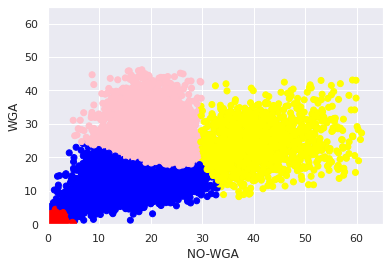

Color-cluster association {'blue': [1, 5735], 'pink': [4, 4143], 'yellow': [3, 1288], 'red': [2, 355], 'green': [0, 220]}


In [11]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 65.0),
                                                 ylim=(0., 65.0))

print("Color-cluster association", color_comp_assoc)

This depends on the clustering above so we need to make sure that colors do align

In [12]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

INFO: Component 0 means [1.39018361e-20 1.38915456e-20] 
INFO: Component 1 means [16.65535114 13.75029052] 
INFO: Component 2 means [0.95813737 0.9702716 ] 
INFO: Component 3 means [39.63359371 24.28362114] 
INFO: Component 4 means [19.64184248 23.31255548] 


state name:  Duplication
State means:  [39.63359371 24.28362114]
State covariance:  [71.53462338 39.47339309]


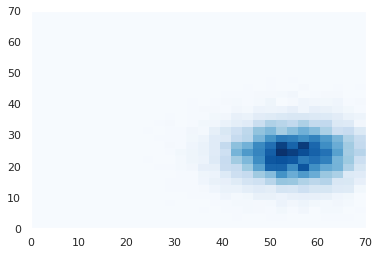

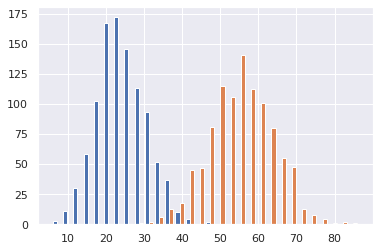

state name:  Normal-I
State means:  [16.65535114 13.75029052]
State covariance:  [31.48814079 19.01925785]


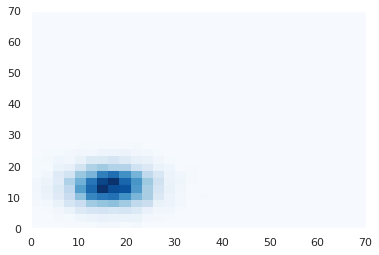

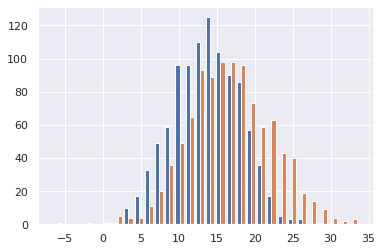

state name:  Normal-II
State means:  [19.64184248 23.31255548]
State covariance:  [19.60618075 52.49115329]


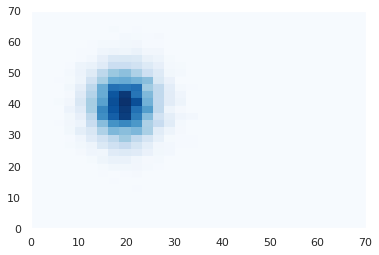

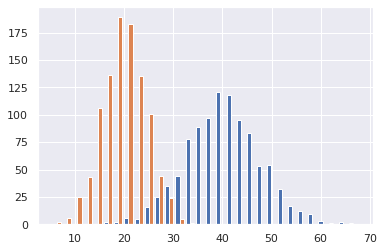

state name:  Deletion
State means:  [0.95813737 0.9702716 ]
State covariance:  [1.19320366 1.10360725]


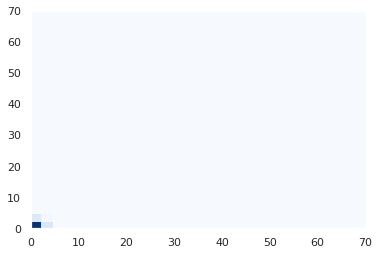

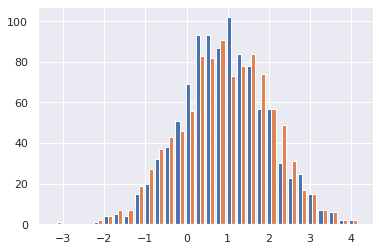

In [13]:
states_map = {"Duplication": 3, "Normal-I": 1, 
              "Normal-II": 4, "Deletion": 2}
plot = True
states={}
for state in states_map:

        print("state name: ", state)
        name = state
        idx = states_map[state]

        # change the order of the means to match the order of the
        # data we will retrieve below in the prediction step
        mu_no_wga = means[idx][0]
        mu_wga = means[idx][1]
        mu = np.array([mu_wga, mu_no_wga])
        print("State means: ", means[idx])
        cov = covariances[idx]
        print("State covariance: ", cov)
        cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])

        if state == "Duplication":
            mu[1] = 55.0
        elif state== 'Normal-II':
            mu[0] = 40.0

        state_dist = MultivariateGaussianDistribution(means=mu,
                                                      covariance=cov)

        if plot:

            if state == "Duplication":
                min_ = 0.0
                max_ = 70.0
            elif state == "Normal-I":
                min_ = 0.0
                max_ = 70.0
            elif state == "Normal-II":
                min_ = 0.0
                max_ = 70.0
            elif state == 'Deletion':
                min_ = 0.0
                max_ = 70.0

            plot_state(state_dist=state_dist,
                       sample_size=10000, n_bins=30,
                       min_=min_, max_=max_)

        states[name] = State(state_dist, name=name)

### Cluster for TUF

Simply use the ref TUF I region to extract the distribution.

In [14]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [15]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  15265.080441017086
Len of labels:  1231


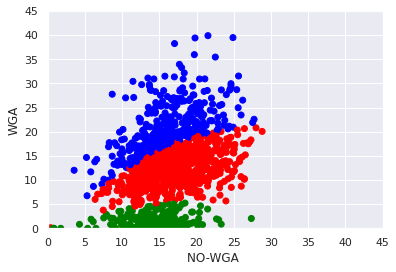

In [16]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=tuf_data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [17]:
print("Color-cluster association for TUF", color_comp_assoc_tuf)

Color-cluster association for TUF {'blue': [1, 371], 'red': [2, 677], 'green': [0, 183]}


In [20]:
tuf_idx = 0

In [21]:
tuf_means = gmm_tuf.means_
tuf_cov = gmm_tuf.covariances_
#states['TUF'] = create_tuf_state(tuf_means=tuf_means[tuf_idx], tuf_cov=tuf_cov[tuf_idx])
print(tuf_means)
print(tuf_cov)

[[14.22027807  1.7345119   0.19150212]
 [16.17140923 20.57959587  1.29798649]
 [17.16081734 12.35078451  0.75266941]]
[[1.56555953e+01 1.92600865e+00 1.10279825e-02]
 [1.81846295e+01 2.86968054e+01 1.10004658e-01]
 [1.67930595e+01 1.21130900e+01 3.52721933e-02]]


In [23]:
# add TUFDUP state

extra_var = 259.02221350223147

tufdup_means=tuf_means[tuf_idx]

tufdup_mu_no_wga = 85.0
tufdup_mu_wga = tufdup_means[1]

tufdup_mu = np.array([tufdup_mu_wga, tufdup_mu_no_wga])
tufdup_cov = tuf_cov[tuf_idx]

tufdup_wga_var = tufdup_cov[1]
tufdup_no_wga_var = tufdup_cov[0]

tufdup_cov_use = np.array([[tufdup_wga_var, 0.0], [0.0, tufdup_no_wga_var + 0.30*extra_var]])

tufdup_dist = MultivariateGaussianDistribution(means=tufdup_mu,
                                                covariance=tufdup_cov_use)

states['TUFDUP'] = State(tufdup_dist, name='TUFDUP')

In [24]:
# only change the means

tuf_extra_means=tuf_means[tuf_idx]
tuf_extra_covs = tuf_cov[tuf_idx]

tuf_mu = np.array([tuf_extra_means[1], 40.0])
tuf_cov_new = tuf_extra_covs

tuf_wga_var = tuf_cov_new[1]
tuf_no_wga_var = tuf_cov_new[0]

tufcov_new = np.array([[tuf_wga_var, 0.0], 
                       [0.0, tuf_no_wga_var + 0.05*extra_var]])
print(tufcov_new)
# also add the dist that is not modeled by the data
tuf_dist_double = MultivariateGaussianDistribution(means=tuf_mu,
                                                       covariance=tufcov_new)

# change the TUF state second component

[[ 1.92600865  0.        ]
 [ 0.         28.60670596]]


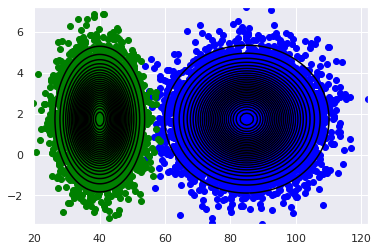

In [25]:
from scipy.stats import kde

nbins = 80
tufdump_data = tufdup_dist.sample(n=10000)
state_no_wga_obs_tufdp = tufdump_data[:,[1]].flatten()
state_wga_obs_tufdp = tufdump_data[:,[0]].flatten()

min_x = min(state_no_wga_obs_tufdp)
max_x = max(state_no_wga_obs_tufdp)

min_y = min(state_wga_obs_tufdp)
max_y = max(state_wga_obs_tufdp)

plt.scatter(state_no_wga_obs_tufdp, state_wga_obs_tufdp , color='blue')
#kernel = kde.gaussian_kde(np.vstack([state_no_wga_obs_tufdp, state_wga_obs_tufdp]))

xi, yi = np.mgrid[min([min_x]):max([max_x]):nbins * 1j,
                  min([min_y]):max([max_y]):nbins * 1j]

zi = []
valsxi = xi[:, [0]]

for obs_no_wga in valsxi:
    for obs_wga in yi[0]:
         zi.append(tufdup_dist.probability((obs_wga, obs_no_wga)))

zi = np.array(zi)
zi = zi.reshape(yi.shape)
plt.contour(xi, yi, zi, 34, colors='black')


tuf_data = tuf_dist_double.sample(n=10000)
state_no_wga_obs_tuf = tuf_data[:,[1]].flatten()
state_wga_obs_tuf = tuf_data[:,[0]].flatten()

min_x = min(state_no_wga_obs_tuf)
max_x = max(state_no_wga_obs_tuf)

min_y = min(state_wga_obs_tuf)
max_y = max(state_wga_obs_tuf)

plt.scatter(state_no_wga_obs_tuf, state_wga_obs_tuf , color='green')
#kernel = kde.gaussian_kde(np.vstack([state_no_wga_obs_tuf, state_wga_obs_tuf]))

xi, yi = np.mgrid[min([min_x]):max([max_x]):nbins * 1j,
                  min([min_y]):max([max_y]):nbins * 1j]

#zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))

zi = []
valsxi = xi[:, [0]]

for obs_no_wga in valsxi:
    for obs_wga in yi[0]:
         zi.append(tuf_dist_double.probability((obs_wga, obs_no_wga)))

zi = np.array(zi)
zi = zi.reshape(yi.shape)
plt.contour(xi, yi, zi, 34, colors='black')

#plt.contour(xi, yi, zi.reshape(xi.shape), 34, colors='black')

plt.show()

## Create HMM

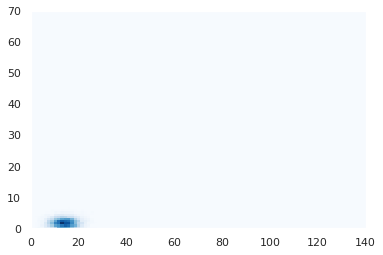

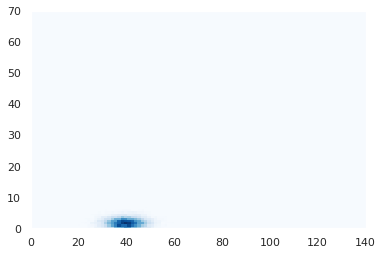

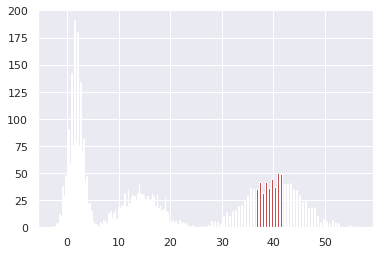

In [29]:
means=tuf_means[tuf_idx]
mu_no_wga = means[0]
mu_wga = means[1]

comp1_means = np.array([mu_wga, mu_no_wga])
cov = tuf_cov[tuf_idx]

wga_var = cov[1]
no_wga_var = cov[0]

comp1_cov = np.array([[wga_var, 0.0], [0.0, no_wga_var]])

states['TUF'] = create_tuf_state(comp1_means=comp1_means, comp1_cov=comp1_cov, 
                                 comp2_means=tuf_mu, comp2_cov=tufcov_new)

In [30]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]

In [31]:
gap_state = None
gap_state_dist = None


In [32]:
if configuration["remove_windows_with_gaps"] == False:
    
    name="GAP_STATE"
    
    # we have a gap state then add it
    gap_windows_dist = configuration["gap_windows_dist"]
    gap_state_dist = get_dist_list(dists_name=[gap_windows_dist["name"],
                                               gap_windows_dist["name"]],
                                               params={"uniform_params":gap_windows_dist["config"]["parameters"]})

    gap_state = \
            State(IndependentComponentsDistribution(gap_state_dist), 
                  name=name)
    states[name] = gap_state

In [33]:
print("{0} Number of states: {1}".format(INFO, len(states)))
for state in states:
    print(state)

INFO: Number of states: 7
Duplication
Normal-I
Normal-II
Deletion
TUFDUP
TUF
GAP_STATE


In [34]:
# print info about the states
for name in states:
    state = states[name]
    print("{0} State: {1}".format(INFO, state.name))
    state_map = json.loads(str(state))
    print("{0} Distributions: {1}".format(INFO,
                                          state_map["distribution"]))

# create the HMM
hmm_model = HiddenMarkovModel(name=hmm_config["name"],
                              start=None, end=None)

states_list = []
for state in states:
    states_list.append(states[state])
hmm_model.add_states(states_list)

INFO: State: Duplication
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.283621138294365, 55.0], [[39.473393085057296, 0.0], [0.0, 71.53462337717849]]], 'frozen': False}
INFO: State: Normal-I
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[13.750290519035646, 16.65535114027298], [[19.019257854346822, 0.0], [0.0, 31.488140792022595]]], 'frozen': False}
INFO: State: Normal-II
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[40.0, 19.641842481040367], [[52.49115328954019, 0.0], [0.0, 19.606180750829882]]], 'frozen': False}
INFO: State: Deletion
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[0.970271600267186, 0.958137372653406], [[1.1036072543648185, 0.0], [0.0, 1.1932036611641303]]], 'frozen': False}
INFO: State: TUFDUP
INFO: Distributions: {'class': 'D

In [35]:
# uniform probability for starting the sequence
# for every state
start_prob = 1.0/len(states)
hmm_config["states"]={}

for state in states:
    hmm_config["states"][state] = {"start_prob":start_prob}

In [36]:
print("Startring probabilities....")
for state in states:
    print("State: {0}, probability: {1} ".format(state,hmm_config["states"][state]["start_prob"]))
    

Startring probabilities....
State: Duplication, probability: 0.14285714285714285 
State: Normal-I, probability: 0.14285714285714285 
State: Normal-II, probability: 0.14285714285714285 
State: Deletion, probability: 0.14285714285714285 
State: TUFDUP, probability: 0.14285714285714285 
State: TUF, probability: 0.14285714285714285 
State: GAP_STATE, probability: 0.14285714285714285 


Form the transition probabilities

In [37]:
self_trans = 0.85
off_trans = (1.0 - self_trans)/(len(states) - 1)

print("Self transition: ", self_trans)
print("Off transition: ", off_trans)

hmm_config["transitions"]={}

for state_i in states:
    for state_j in states:
        state_name = state_i + "-" + state_j
        if state_i == state_j:
            hmm_config["transitions"][state_name] = self_trans
        else:
            hmm_config["transitions"][state_name] = off_trans
            
            
# fix the transitions for TUF-Duplication and
# vice-versa
#for state_i in states:
#    for state_j in states:
#        state_name = state_i + "-" + state_j
        
#        if state_i == 'TUF' and state_j == 'Duplication':
#            hmm_config["transitions"][state_name] = 0.0
#        elif state_i == 'Duplication' and state_j == 'TUF':
#            hmm_config["transitions"][state_name] = 0.0

Self transition:  0.85
Off transition:  0.025000000000000005


In [28]:
# change the transitions for TUF
#for state_i in states:
#    for state_j in states:
#        state_name = state_i + "-" + state_j
        
#        if state_i == 'TUF':
            
            # more likely to transition from TUF to Normal
            # than Delete and Duplication or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'Duplication' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003
#        if state_i == 'Duplication':
             # more likely to transition from Duplication to Normal
            # than Delete and TUF or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'TUF' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003

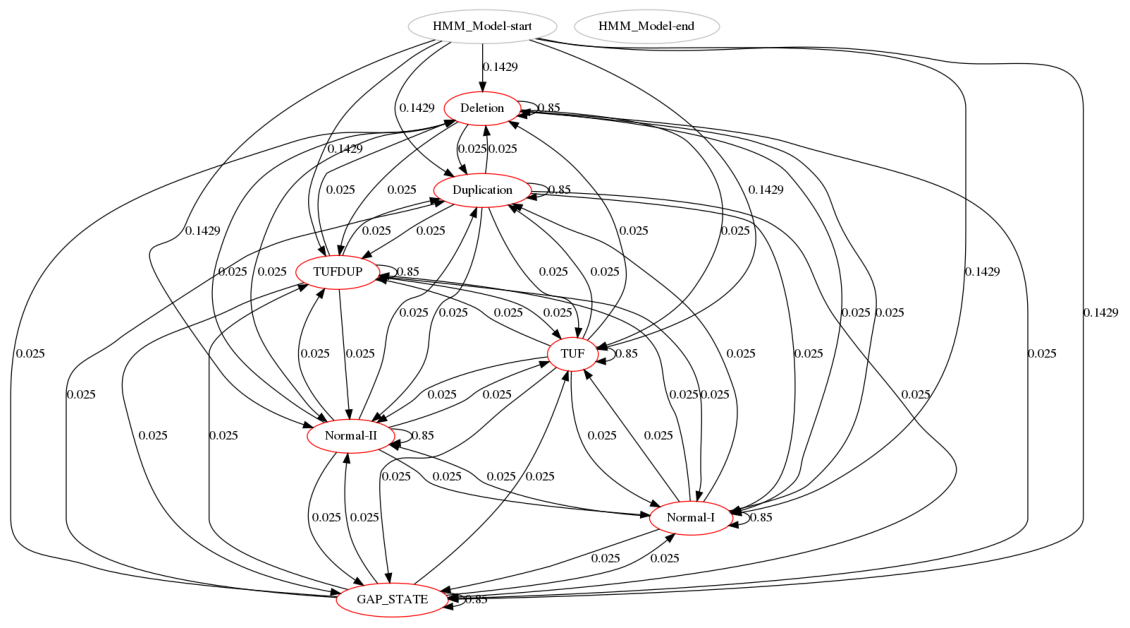

In [38]:
for state in states:
    prob = hmm_config["states"][state]["start_prob"]
    hmm_model.add_transition(hmm_model.start, states[state], prob)

# add transitions for every state
# to another this will create a dense HMM
for state_i in states:
    for state_j in states:
        if state_i + "-" + state_j in hmm_config["transitions"]:
                prob =hmm_config["transitions"][state_i + "-" + state_j]
                hmm_model.add_transition(states[state_i], states[state_j], prob)
        else:
                print("{0} Transition from state"
              " {1} to state {2} is not specified".format(WARNING,
                                                          state_i,
                                                          state_j))

# finally we need to bake
hmm_model.bake(verbose=True)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

In [39]:
hmm_model.dense_transition_matrix()

array([[0.85      , 0.025     , 0.025     , 0.025     , 0.025     ,
        0.025     , 0.025     , 0.        , 0.        ],
       [0.025     , 0.85      , 0.025     , 0.025     , 0.025     ,
        0.025     , 0.025     , 0.        , 0.        ],
       [0.025     , 0.025     , 0.85      , 0.025     , 0.025     ,
        0.025     , 0.025     , 0.        , 0.        ],
       [0.025     , 0.025     , 0.025     , 0.85      , 0.025     ,
        0.025     , 0.025     , 0.        , 0.        ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.85      ,
        0.025     , 0.025     , 0.        , 0.        ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.025     ,
        0.85      , 0.025     , 0.        , 0.        ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.025     ,
        0.025     , 0.85      , 0.        , 0.        ],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714, 0.        , 0.        ],


In [40]:
json_str = hmm_model.to_json()
import json
with open("HMM_Model_9" + ".json", 'w') as jsonfile:
      json.dump(json_str, jsonfile)

## Test

In [39]:
wga_mean_tuf_I_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_TUF_DETAIL_I_MEAN_CUT_OFF.txt"
no_wga_mean_tuf_I_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_TUF_DETAIL_I_MEAN_CUT_OFF.txt"


In [40]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)

tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [41]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  16179.145877308993
Len of labels:  1256


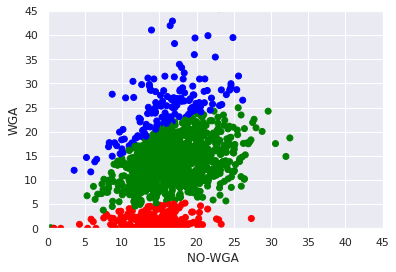

In [42]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=tuf_data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [10]:
wga_mean_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_REGION_1_CHR_2_MEAN_CUTOFF.txt"
no_wga_mean_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_REGION_1_CHR_2_MEAN_CUTOFF.txt"

In [11]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)

In [23]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  2479855.944796673
Len of labels:  189982


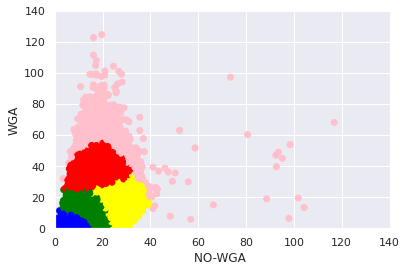

Color-cluster association {'yellow': [3, 67255], 'green': [0, 80859], 'blue': [1, 3654], 'red': [2, 36791], 'pink': [4, 1423]}


In [24]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 140.0),
                                                 ylim=(0., 140.0))

print("Color-cluster association", color_comp_assoc)

In [25]:
means = gmm.means_

for comp in color_comp_assoc:
    print("Component {0} means {1}".format(comp, means[color_comp_assoc[comp][0]]))

#for i in range(len(means)):
#    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

Component yellow means [20.56690233 19.29650375]
Component green means [16.39956765 14.75237815]
Component blue means [11.31531455  4.47601152]
Component red means [18.90303397 27.32795589]
Component pink means [21.13919535 48.48236166]


In [20]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

Number of clusters  6
Converged:  True
BIC:  2474928.721583939
Len of labels:  189982


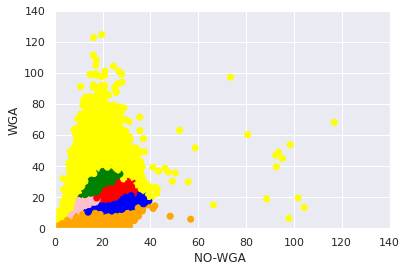

Color-cluster association {'blue': [1, 46686], 'orange': [5, 22946], 'pink': [4, 32162], 'yellow': [3, 15994], 'red': [2, 35286], 'green': [0, 36908]}


In [21]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=6, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 140.0),
                                                 ylim=(0., 140.0))

print("Color-cluster association", color_comp_assoc)

In [22]:
means = gmm.means_

for comp in color_comp_assoc:
    print("Component {0} means {1}".format(comp, means[color_comp_assoc[comp][0]]))


Component blue means [20.47286507 14.23060091  0.720048  ]
Component orange means [17.16275585  6.99530901  0.45876114]
Component pink means [14.4552282  16.66629337  1.15594007]
Component yellow means [16.47748395 36.3278856   2.23152649]
Component red means [21.76961136 21.86703633  1.01311469]
Component green means [18.02839805 27.61877213  1.52729169]
